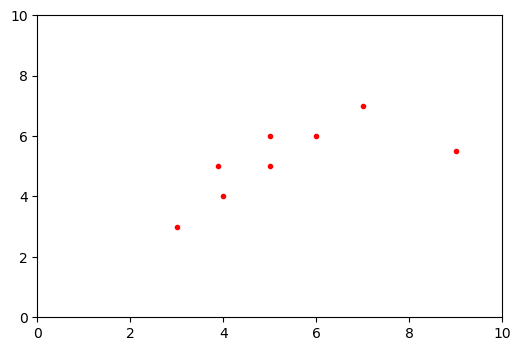

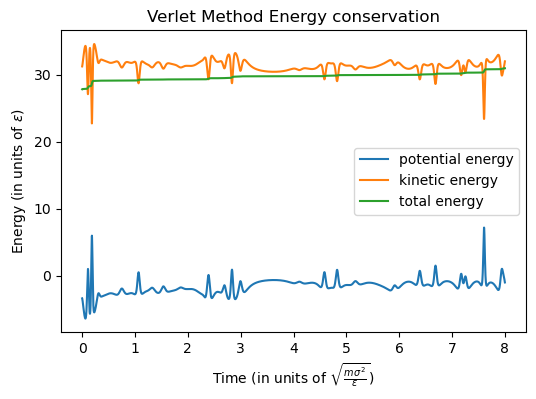

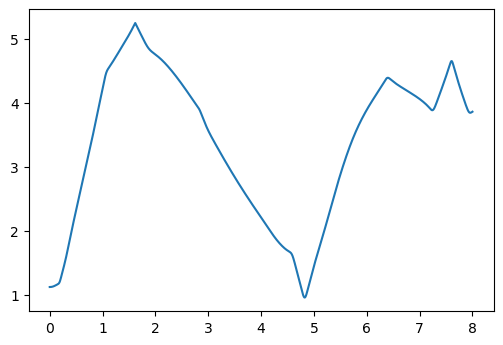

In [12]:
"""
This is a suggestion for structuring your simulation code properly.
However, it is not set in stone. You may modify it if you feel like
you have a good reason to do so.
"""
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation
import time

plt.rcParams['figure.dpi']=100
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['animation.convert_path'] = "F:/Python"

### Constants ###
k_B = 1.380649e-23  #J K^-1
eps = 119.8 * k_B   # J
sigma = 3.405       # Angstrom
m = 6.6e-26         # kg

def simulate(init_pos, init_vel, num_tsteps, timestep, box_dim):
    """
    Molecular dynamics simulation using the Euler or Verlet's algorithms
    to integrate the equations of motion. Calculates energies and other
    observables at each timestep.

    Parameters
    ----------
    init_pos : np.ndarray
        The initial positions of the atoms in Cartesian space
    init_vel : np.ndarray
        The initial velocities of the atoms in Cartesian space
    num_tsteps : int
        The total number of simulation steps
    timestep : float
        Duration of a single simulation step
    box_dim : float
        Dimensions of the simulation box

    Returns
    -------
    Any quantities or observables that you wish to study.
    x : all positions
    v : all velocities
    E : energy at every time step
    p : all momenta
    """
    h = timestep # Shorther way to deal with timestep :)
    x = np.ndarray(shape = (num_tsteps, num_atoms, 2)) # Stores velocities for every timestep
    v = np.ndarray(shape = (num_tsteps, num_atoms, 2)) # Stores positions for every timestep
    F = np.ndarray(shape = (num_tsteps, num_atoms, 2)) # Stores force for every timestep
    r = np.zeros(num_tsteps)

    T = np.zeros(num_tsteps) # Kinetic energy
    U = np.zeros(num_tsteps) # Potential energy    
    
    # Initialize position, velocity and force
    x[0] = init_pos
    v[0] = init_vel

    # Calculate the energies and force for thwe first timestep
    rel_pos, rel_dist = atomic_distances(x[0], box_dim)
    U[0] = potential_energy(rel_dist)
    T[0] = kinetic_energy(v[0])
    F[0] = lj_force(rel_pos, rel_dist)
    r[0] = rel_dist[1, 0]

    for i in range(1, num_tsteps):
      
        rel_pos, rel_dist = atomic_distances(x[i-1], box_dim)
        F[i] = lj_force(rel_pos, rel_dist)
        r[i] = rel_dist[1, 0]

        # Verlet method to calculate new position and velocity
        x[i] = x[i - 1] + v[i - 1] * h + (h**2 / 2) * F[i]
        v[i] = v[i - 1] + (h / 2) * ( F[i] + F[i - 1] )

        
        #Euler method to calculate new position and velocity
        #x[i] = x[i - 1] + v[i - 1] * h
        #v[i] = v[i - 1] + F[i - 1] * h


        # Periodic boundary conditions
        x[i, :, 0] = np.where( x[i, :, 0] < box_dim  , x[i, :, 0], x[i, :, 0] % box_dim)
        x[i, :, 0] = np.where( x[i, :, 0] > 0        , x[i, :, 0], x[i, :, 0] % box_dim)
        x[i, :, 1] = np.where( x[i, :, 1] < box_dim  , x[i, :, 1], x[i, :, 1] % box_dim)
        x[i, :, 1] = np.where( x[i, :, 1] > 0        , x[i, :, 1], x[i, :, 1] % box_dim)

        # Calculate the energies
        T[i] = kinetic_energy(v[i])
        U[i] = potential_energy(rel_dist)
    
        #print("x[%s]: \n" %i, x[i])
        #print("v[%s]: \n" %i, v[i])

    return (x, v, T, U, r)

def atomic_distances(pos, box_dim):
    """
    Calculates relative positions and distances between particles.

    parameters
    ----------
    pos : np.ndarray
        The positions of the particles in cartesian space
    box_dim : float
        The dimension of the simulation box

    returns
    -------
    rel_pos : np.ndarray
        Relative positions of particles
    rel_dist : np.ndarray
        The distance between particles
    """
    rel_pos = pos[:, np.newaxis] - pos

    rel_pos = np.where(rel_pos < (-box_dim / 2), rel_pos + box_dim, rel_pos) #distances smaller than -size/2 get + size term
    rel_pos = np.where(rel_pos > ( box_dim / 2), rel_pos - box_dim, rel_pos)  #distances larger than size/2 get - size ter

    rel_dist = np.linalg.norm(rel_pos, axis=2)    
    return (rel_pos, rel_dist)


def lj_force(rel_pos, rel_dist):
    """
    Calculates the net forces on each atom.

    Parameters
    ----------
    rel_pos : np.ndarray
        Relative particle positions as obtained from atomic_distances
    rel_dist : np.ndarray
        Relative particle distances as obtained from atomic_distances

    Returns
    -------
    np.ndarray
        The net force acting on particle i due to all other particles
    """
    r = np.array([rel_dist]*2).transpose()
    F = rel_pos * ( 48 * np.power(r, -14, where= r!=0) - 24 * np.power(r, -8, where= r!=0) )
    F = np.sum(F, axis=1)
    return F


def fcc_lattice(num_atoms, lat_const):
    """
    Initializes a system of atoms on an fcc lattice.

    Parameters
    ----------
    num_atoms : int
        The number of particles in the system
    lattice_const : float
        The lattice constant for an fcc lattice

    Returns
    -------
    pos_vec : np.ndarray
        Array of particle coordinates
    """
    N = num_atoms  
    n = 2
    m = N**(1/n)
    dx = lat_const/(m+1) 
    x_T = []
    for i in range(N):  
        x = np.zeros(n)
        for k in range(n):
            x[k] = dx * int(1 + m * (i % m**(k+1) / m**(k+1)))
        x_T.append(x)    
    return np.array(x_T)

def kinetic_energy(vel):
    """
    Computes the kinetic energy of an atomic system.

    Parameters
    ----------
    vel: np.ndarray
        Velocity of particle

    Returns
    -------
    float
        The total kinetic energy of the system.
    """
    T = np.linalg.norm(vel, axis=1)
    T = 1/2 * np.power(T, 2)
    return np.sum(T)


def potential_energy(rel_dist):
    """
    Computes the potential energy of an atomic system.

    Parameters
    ----------
    rel_dist : np.ndarray
        Relative particle distances as obtained from atomic_distances

    Returns
    -------
    float
        The total potential energy of the system.
    """
    r = np.copy(rel_dist)
    U = 4 * (np.power(r, -12, where=~np.isclose(r,0)) - np.power(r, -6, where=~np.isclose(r,0)) )
    U = np.sum(U)    
    return U / 2

def init_velocity(num_atoms, temp):
    """
    Initializes the system with Gaussian distributed velocities.

    Parameters
    ----------
    num_atoms : int
        The number of particles in the system.
    temp : float
        The (unitless) temperature of the system.

    Returns
    -------
    vel_vec : np.ndarray
        Array of particle velocities
    """
    return np.random.normal(0, 5, (num_atoms, 2))


num_tsteps = 20000
num_atoms = 8
box_dim = 10
timestep = 0.0004


np.random.seed(1)
init_vel = np.array([[0,0],[0,1],[1,0],[0.5,0.5],[1,1],[2,2],[3,3],[4,4]])
init_pos = np.array([[5,5],[5 - 2**(1/6),5],[5,6],[4,4],[9,5.5],[6,6],[7,7],[3,3]])
x, v, T, U, r = simulate(init_pos, init_vel, num_tsteps, timestep, box_dim)

"""
N = 1000
UT = np.zeros(N)
for i in range(N):
    x, v, T, U = simulate(init_pos, init_vel, num_tsteps, timestep, box_dim)
    UT[i] = U[0]

plt.plot(UT)
"""

# Animation and plotting stuff
frames = num_tsteps
fig, ax = plt.subplots()
for k in range(len(x[0])):
    ax.plot(x[0,k,0], x[0,k,1], 'r.')
ax.set_xlim(0, box_dim)
ax.set_ylim(0, box_dim)

def animate(i):
    ax.clear()
    ax.set_xlim(0, box_dim)
    ax.set_ylim(0, box_dim)
    for k in range(len(x[0])):
        ax.plot(x[i,k,0], x[i,k,1], 'r.')
    
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=1)
anim
#anim.save('Figures-animations/test2.gif', writer='imagemagick', fps=30)

# print(T)
# print(U)

plt.figure(2)
t = timestep * np.arange(0,num_tsteps)
plt.plot(t, U, label = 'potential energy')
plt.plot(t, T, label = 'kinetic energy')
plt.plot(t, T + U, label = 'total energy')
plt.xlabel(r'Time (in units of $\sqrt{\frac{m\sigma^2}{\epsilon}}$)')
plt.ylabel(r'Energy (in units of $\epsilon$)')
plt.legend()
plt.title('Verlet Method Energy conservation')
plt.savefig('Verlet Method Energy conservation.png')


plt.figure(3)
plt.plot(t, r)
plt.show()